In [109]:
import csv
import numpy as np
import torch 


from loguru import logger
from multiprocessing import Pool, cpu_count
from pathlib import Path
from transformers import DistilBertConfig, DistilBertForSequenceClassification, DistilBertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import matthews_corrcoef, confusion_matrix, f1_score
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from tqdm.notebook import tqdm, trange

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
class InputExample():
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Construct an InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence.
            text_b: (Optional) string. The untokenized text of the second
            sequence. Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def convert_example_to_feature(example_row):
    """
    Loads a data file into a list of ``InputFeatures``
    Args:
        example_row mappings:
        examples: List of ``InputExamples`` or ``tf.data.Dataset`` containing the examples.
        tokenizer: Instance of a tokenizer that will tokenize the examples
        max_seq_length: Maximum example length
        label_list: List of labels.
        output_mode: String indicating the output mode. Either ``regression`` or ``classification``
        pad_on_left: If set to ``True``, the examples will be padded on the left rather than on the
                    right (default)
        pad_token: Padding token
        pad_token_segment_id: The segment ID for the padding token (It is usually 0,
                              but can vary such as for XLNet where it is 4)
        mask_padding_with_zero: If set to ``True``, the attention mask will be filled by ``1``
            for actual values and by ``0`` for padded values. If set to ``False``, inverts it (``1``
            for padded values, ``0`` for actual values)
    Returns:
        If the ``examples`` input is a ``tf.data.Dataset``, will return a ``tf.data.Dataset``
        containing the task-specific features. If the input is a list of ``InputExamples``, will return
        a list of task-specific ``InputFeatures`` which can be fed to the model.
    """
    # return example_row
    example, label_map, max_seq_length, tokenizer, output_mode, \
    pad_on_left, pad_token, pad_token_segment_id, mask_padding_with_zero = example_row

    inputs = tokenizer.encode_plus(example.text_a,
                                   example.text_b,
                                   add_special_tokens=True,
                                   max_length=max_seq_length)

    input_ids, token_type_ids = inputs["input_ids"], inputs["token_type_ids"]

    # The mask has 1 for real tokens and 0 for padding tokens. Only real tokens are attended to.
    attention_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)
    # Zero-pad up to the sequence length.
    padding_length = max_seq_length - len(input_ids)

    if pad_on_left:
        input_ids = ([pad_token] * padding_length) + input_ids
        attention_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + attention_mask
        token_type_ids = ([pad_token_segment_id] * padding_length) + token_type_ids
    else:
        input_ids = input_ids + ([pad_token] * padding_length)
        attention_mask = attention_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
        token_type_ids = token_type_ids + ([pad_token_segment_id] * padding_length)

    if output_mode == "classification":
        label_id = label_map[example.label]
    elif output_mode == "regression":
        label_id = float(example.label)
    else:
        raise KeyError(output_mode)

    return InputFeatures(input_ids=input_ids,
                         attention_mask=attention_mask,
                         token_type_ids=token_type_ids,
                         label=label_id)

In [44]:
class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def __init__(self, labels=None):
        self._labels=labels

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_test_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def set_labels(self, labs):
        self._labels = labs

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                lines.append(line)
            return lines

In [45]:
class ClassificationProcessor(DataProcessor):
    """Processor for multi-class classification dataset"""

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(data_dir / 'train.tsv'), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(data_dir / 'dev.tsv'), "dev")

    def get_labels(self):
        """See base class."""
        return self._labels

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (_, line) in enumerate(lines):
            guid = "%s-%s" % (set_type, line[0])
            text_a = line[3]
            label = line[1]
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

In [47]:
# Data Folder
data_folder = Path.home() / 'Data' / 'cc_news'
model_input_folder = data_folder / 'model_input'
train_file = model_input_folder / 'train.tsv'
dev_file = model_input_folder / 'dev.tsv'

In [48]:
# Get your train examples
processor = ClassificationProcessor()

In [49]:
# Set labels 
labels = ['politics', 'sports', 'business_economy', 'world', 'entertainment']
num_labels = len(labels)
# Let the processor know what the labels are
processor.set_labels(labels)

# Create Label to Index Map 
label_map = {label: i for i, label in enumerate(labels)}

In [91]:
# Set model Hyper Parameters
max_seq_length = 256
train_batch_size = 32
gradient_accumulation_steps = 2
num_train_epochs = 3
learning_rate = 2e-5

output_mode = 'classification'
bert_model = 'distilbert-base-uncased'
cache_dir = 'cache/'
model_type = 'distilbert'

processor_count = cpu_count() - 1

In [61]:
# Load Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(bert_model, do_lower_case=True)

In [62]:
train_examples = processor.get_train_examples(model_input_folder)

In [69]:
pad_on_the_left = False
pad_token = tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0]
pad_token_segment_id = 0
mask_padding_with_zero = True
examples = [(example, label_map, max_seq_length, tokenizer, output_mode, pad_on_the_left,
                     pad_token, pad_token_segment_id, mask_padding_with_zero)
                    for example in train_examples]

In [73]:
with Pool(processor_count) as proc:
    features = list(tqdm(proc.imap(convert_example_to_feature, examples), total=len(train_examples)))

In [75]:
def convert_to_tensors(features):
    """Get your Feature Vectords into the tensors."""
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_masks = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_labels = torch.tensor([f.label for f in features], dtype=torch.long)

    dataset = TensorDataset(all_input_ids, all_attention_masks, all_token_type_ids, all_labels)

    return dataset

In [83]:
num_training_steps = int(len(features) / train_batch_size / gradient_accumulation_steps) * num_train_epochs

In [84]:
train_data = convert_to_tensors(features)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size)

In [93]:
model = DistilBertForSequenceClassification.from_pretrained(bert_model, cache_dir=cache_dir, num_labels=num_labels)

In [94]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (dropout): Dropout(p=0.1, inplace=False)
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
         

In [95]:
param_optimizer = model.named_parameters()
no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [{'params':
                                 [p for n, p in param_optimizer
                                  if not any(nd in n for nd in no_decay)],
                                 'weight_decay': 0.00},
                                {'params':
                                 [p for n, p in param_optimizer
                                  if any(nd in n for nd in no_decay)],
                                 'weight_decay': 0.0}]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, correct_bias=False)

num_warmup_steps = int(num_training_steps * 0.1)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=num_warmup_steps,
                                            num_training_steps=num_training_steps)

In [96]:
global_step = 0
nb_tr_steps = 0
tr_loss = 0
train_loss_set = []
model.zero_grad()

In [97]:
logger.info("***** Running training...")
logger.info(f"  Num examples = {len(train_data)}")
logger.info(f"  Batch size = {train_batch_size}")
logger.info(f"  Num steps = {num_training_steps}")

2020-01-09 22:26:33.985 | INFO     | __main__:<module>:1 - ***** Running training...
2020-01-09 22:26:33.987 | INFO     | __main__:<module>:2 -   Num examples = 3302
2020-01-09 22:26:33.987 | INFO     | __main__:<module>:3 -   Batch size = 32
2020-01-09 22:26:33.988 | INFO     | __main__:<module>:4 -   Num steps = 153


In [98]:
for _ in trange(int(num_train_epochs), desc="Epoch"):

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Iterating through batches
    for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
        # Set our model to training mode (as opposed to evaluation mode)
        model.train()
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[3]}\

        if model_type != 'distilbert':
            inputs['token_type_ids'] = batch[2] if model_type in ['bert', 'xlnet'] else None

        outputs = model(**inputs)
        loss = outputs[0]
        train_loss_set.append(loss)

        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps

        
        
        loss.backward()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += inputs["input_ids"].size(0)
        nb_tr_steps += 1

        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

            print("\r%f" % loss, end='')

            optimizer.step()
            scheduler.step()
            model.zero_grad()
            global_step += 1

logger.info("******* END OF TRAINING ******")
logger.info(f"Train loss: {tr_loss/nb_tr_steps}")

0.032601


0.010957


0.071421

2020-01-09 22:28:45.739 | INFO     | __main__:<module>:44 - ******* END OF TRAINING ******
2020-01-09 22:28:45.740 | INFO     | __main__:<module>:45 - Train loss: 0.06205301140793241


0.027352



In [99]:
# Evaluation
dev_examples = processor.get_dev_examples(model_input_folder)
examples = [(example, label_map, max_seq_length, tokenizer, output_mode, pad_on_the_left,
                     pad_token, pad_token_segment_id, mask_padding_with_zero)
                    for example in dev_examples]

In [100]:
with Pool(processor_count) as proc:
    features = list(tqdm(proc.imap(convert_example_to_feature, examples), total=len(dev_examples)))

In [101]:
dev_data = convert_to_tensors(features)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=train_batch_size)

In [111]:
def accuracy(preds, labels):
    """Calculate the accuracy of our predictions vs labels."""
    return (preds == labels).mean()

def compute_metrics(preds, labels):
    mcc = round(matthews_corrcoef(labels, preds), 4)
    f1 = round(f1_score(labels, preds, average='macro'), 4)
    acc = round(accuracy(preds, labels), 4)

    metrics = {'metrics':{'acc': acc, 'mcc': mcc, 'f1': f1}}
    return metrics

In [113]:
# Initialize variables
eval_loss = 0.0
nb_eval_steps = 0
preds = None
results = {}
out_label_ids = None

logger.info(f"***** Evaluating...*****")
logger.info(f"  Num examples = {len(dev_data)}")
logger.info(f"  Batch size = {train_batch_size}")

# Evaluate dev 
for batch in tqdm(dev_dataloader, desc="Evaluating..."):
    model.eval()
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[3]}
        if model_type != 'distilbert':
            inputs['token_type_ids'] = batch[2] if model_type in ['bert', 'xlnet'] else None
        # Forward pass, calculate logit predictions
        outputs = model(**inputs)
        tmp_eval_loss, logits = outputs[:2]
        eval_loss += tmp_eval_loss.mean().item()
    nb_eval_steps += 1

    if preds is None:
        preds = logits.detach().cpu().numpy()
        out_label_ids = inputs['labels'].detach().cpu().numpy()
    else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
        out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

preds = np.argmax(preds, axis=1)
metrics = compute_metrics(preds, out_label_ids)
eval_loss = round(eval_loss / nb_eval_steps, 4)
metrics['metrics'].update({"eval_loss": eval_loss})
results.update(metrics)
logger.info(f"Outputting results...")
print(results)

2020-01-09 22:50:25.851 | INFO     | __main__:<module>:8 - ***** Evaluating...*****
2020-01-09 22:50:25.852 | INFO     | __main__:<module>:9 -   Num examples = 367
2020-01-09 22:50:25.852 | INFO     | __main__:<module>:10 -   Batch size = 32


2020-01-09 22:50:27.460 | INFO     | __main__:<module>:42 - Outputting results...



{'metrics': {'acc': 0.921, 'mcc': 0.8912, 'f1': 0.9092, 'eval_loss': 0.2526}}


In [116]:
cm = confusion_matrix(out_label_ids, preds)
print(f'Overall Accurcy: {round(cm.diagonal().sum()*100/len(out_label_ids),2)}')
print(f'There are {len(out_label_ids)} records in the Test Set')
print(f'Of those {cm.diagonal().sum()} are correctly assigned')

Overall Accurcy: 92.1
There are 367 records in the Test Set
Of those 338 are correctly assigned


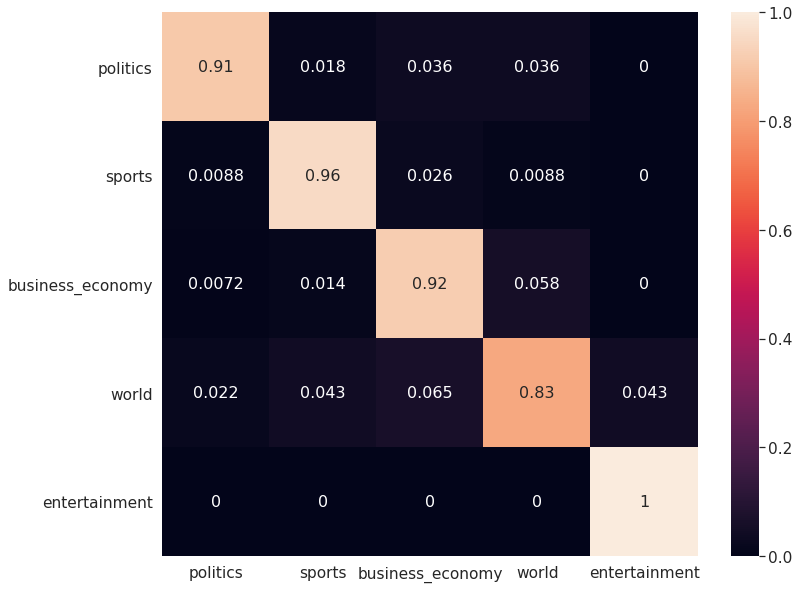

In [123]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize = (12,10))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})